In [1]:
%%spark

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1586491211808_0002,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
import pyspark.sql.functions as F
import pyspark.sql.types as T


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#load from URL
#from pyspark import SparkFiles


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:

sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("seaborn")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#from rdkit import Chem
#import deepchem as dc

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached seaborn-0.10.0-py3-none-any.whl (215 kB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)

## Bace analysis

In [5]:
pd_df= pd.read_csv('https://github.com/jtwang1027/pyspark_aws/raw/master/bace.csv')
pd_df.drop('canvasUID',axis=1,inplace=True)
pd_mol2vec=pd.read_csv('https://github.com/jtwang1027/pyspark_aws/raw/master/mol2vec.csv',header=None)

#concatenating two df (adding columns) is a pain in Spark, we'll just do it pandas
pd_comb=pd.concat([pd_df,pd_mol2vec],axis=1)
print(pd_comb.shape) #594 cols from w2v + 300 col from w2v

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1513, 894)

In [6]:
#going from URL directly to spark df example
#url2='https://github.com/jtwang1027/pyspark_aws/raw/master/mol2vec.csv'
#spark.sparkContext.addFile(url2)
#temp = spark.read.csv("file://"+SparkFiles.get("mol2vec.csv"), header=False, inferSchema= True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

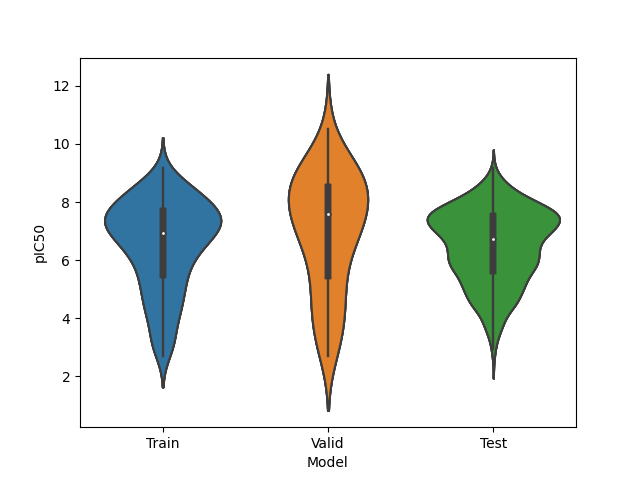

In [42]:
#sns.violinplot(pd_df.Model, pd_df['pIC50'])
#%matplot plt

In [11]:
df=spark.createDataFrame(pd_df) 
df_m2v=spark.createDataFrame(pd_comb) #df + mol2vec

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
import re

#rename columns to replace periods . and parentheses, which would trigger syntax error in Pyspark
df=df.toDF(*(re.sub(r'[\.\s]+', '', c) for c in df.columns))
df=df.toDF(*(re.sub(r'\([^)]*\)', '', c) for c in df.columns))

df_m2v=df_m2v.toDF(*(re.sub(r'[\.\s]+', '_', c) for c in df_m2v.columns))
df_m2v=df_m2v.toDF(*(re.sub(r'\([^)]*\)', '_', c) for c in df_m2v.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
#defining Pipeline for: df
assembler=VectorAssembler(inputCols= df.columns[5:], outputCol= 'pre-scaled')
scaling= StandardScaler(inputCol='pre-scaled', outputCol='features', withStd=True, withMean=False)
pipeline1= Pipeline( stages=[assembler, scaling])

#second assembler for m2v with additional columns (has more columns that has to be assembled)
assembler2=VectorAssembler(inputCols= df_m2v.columns[5:], outputCol= 'pre-scaled')
pipeline2= Pipeline( stages=[assembler2, scaling])

#fitting pipeline on both datasets
df_scaled=pipeline1.fit(df).transform(df)
df_m2v_scaled=pipeline2.fit(df_m2v).transform(df_m2v)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
#splitting into train/test/validation, predefined for this dataset based on Model column
train= df_scaled.filter(col('Model')=='Test') #"Test" has more rows, use for training
test= df_scaled.filter(col('Model')=='Train') #203 rows
validation= df_scaled.filter(col('Model')=='Valid') #45 rows

#train/test/split the second dataframe 
train_m2v= df_m2v_scaled.filter(col('Model')=='Test') #"Test" has more rows, use for training
test_m2v= df_m2v_scaled.filter(col('Model')=='Train') #203 rows
validation_m2v= df_m2v_scaled.filter(col('Model')=='Valid') #45 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
print("Training rows: " + str( train.count()))
print("Testing rows: " + str( validation.count()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training rows: 1265
Testing rows: 45

## Multiple linear regression

In [100]:
lr=LinearRegression(labelCol='pIC50').fit(train)
#lr_model=lr.transform(test)
summary=lr.evaluate(test)
print("RMSE from Linear Regression Model: {}".format(summary.rootMeanSquaredError))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RMSE from Linear Regression Model: 1021.3717331658879

In [18]:
lr_model.select('prediction','pIC50').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+---------+
|       prediction|    pIC50|
+-----------------+---------+
|7.401092107058915|9.1549015|
|7.981737092607418|8.8538723|
| 8.19772365439188|8.6989698|
|7.828743028185393|8.6989698|
|8.192836444033482|8.6989698|
+-----------------+---------+
only showing top 5 rows

## Elastic Net with hyperparameter tuning via CV

In [21]:
#regparam= lambda, weight of regularization
#elasticNetParam= alpha, weighting of L1 vs L2 norm
enet=LinearRegression(featuresCol='features', labelCol='pIC50')
paramGrid=(ParamGridBuilder()
             .addGrid(enet.regParam, [0.01, 0.01, 0.5, 0.9])
             .addGrid(enet.elasticNetParam, [0.0,0.25, 0.5,0.75, 1.0])
             .addGrid(enet.maxIter, [10])
             .build())

evaluator=RegressionEvaluator( predictionCol='prediction',labelCol='pIC50',metricName='rmse')

cv = CrossValidator(estimator=enet, estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=5)

cvMod=cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [101]:
#select and evaluate the best model
enet_best=cvMod.bestModel
enet_summ=enet_best.evaluate(test)
print("RMSE from Elastic Net: {}".format(enet_summ.rootMeanSquaredError))

#enet_pred=enet_best.transform(test)
#cvMod.bestModel.getParam('regParam')
#cvMod.bestModel.getParam('elasticNetParam')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RMSE from Elastic Net: 650.1216346069406

In [102]:
#use models to generate predictions
lr_pred=lr.transform(test)
enet_pred=enet_best.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [103]:
#convert to pandas df for plotting and visualization
lr_pd=lr_pred.select('CID','prediction','pIC50').toPandas()
enet_pd=enet_pred.select('CID','prediction').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [104]:
lr_pd.rename(columns={'prediction':'LinReg'},inplace=True)
enet_pd.rename(columns={'prediction':'Elastic N'},inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [105]:
pd_both=pd.merge(lr_pd, enet_pd,on='CID' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [106]:
pd_both.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      CID    LinReg     pIC50  Elastic N
0  BACE_1  7.401092  9.154901   7.059575
1  BACE_2  7.981737  8.853872   7.380414
2  BACE_3  8.197724  8.698970   7.974156
3  BACE_4  7.828743  8.698970   7.444383
4  BACE_5  8.192836  8.698970   8.020259

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

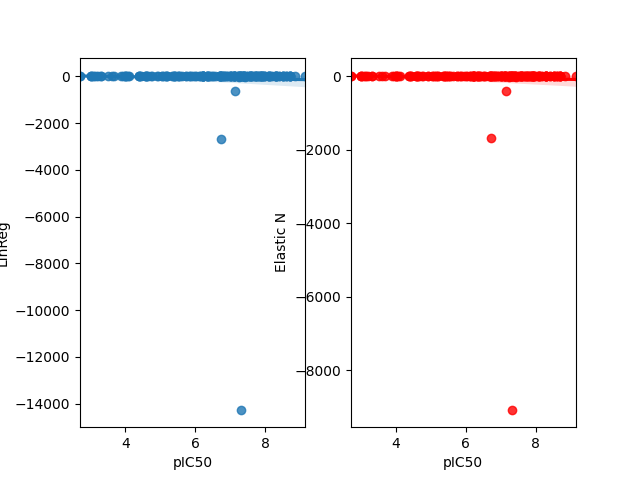

In [107]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

ax1.title.set_text('Linear Regressio')
sns.regplot(x='pIC50',y='LinReg', data= pd_both, ax=ax1)

ax1.title.set_text('Elastic Net')
sns.regplot(x='pIC50',y='Elastic N', data= pd_both, ax=ax2, color='r')

%matplot plt

In [112]:
#pinpointing outliers
outliers=abs(pd_both.pIC50-pd_both.LinReg).nlargest(3)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

74     14290.144740
112     2673.429349
87       640.494588
dtype: float64

## Gradient-boosted tree regression

In [32]:
# Specify a GBT model
gbt_model = GBTRegressor(featuresCol="features", maxIter=10,labelCol='pIC50',  predictionCol='prediction')

# GBT training on both models
gbt = gbt_model.fit(train)

gbt_m2v = gbt_model.fit(train_m2v)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
# Make predictions.
gbt_pred = gbt.transform(validation)
gbt_pred_m2v = gbt_m2v.transform(validation_m2v)

# Select example rows to display.
#gbt_pred.select("prediction", "pIC50").show(5)

evaluator=RegressionEvaluator( predictionCol='prediction', labelCol='pIC50',metricName='rmse')

# Select (prediction, true label) and compute test error
rmse=evaluator.evaluate(gbt_pred)
rmse_m2v=evaluator.evaluate(gbt_pred_m2v)
print("RMSE from GB Trees: {}".format(rmse))
print("RMSE from GB Trees with mo2lvec: {}".format(rmse_m2v))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RMSE from GB Trees: 1.653787014985841
RMSE from GB Trees with mo2lvec: 1.5507920614639628

In [30]:
gbt_model

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

GBTRegressor_d50e0e352f45

In [79]:
#convert to pandas df for plotting and visualization
gbt_pd=gbt_pred.select('CID','prediction','pIC50').toPandas()
gbt_m2v_pd=gbt_pred_m2v.select('CID','prediction').toPandas()

gbt_pd.rename(columns={'prediction':'Standard'},inplace=True)
gbt_m2v_pd.rename(columns={'prediction':'m2v'},inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
pd_gbt=pd.merge(gbt_pd,gbt_m2v_pd,on='CID' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

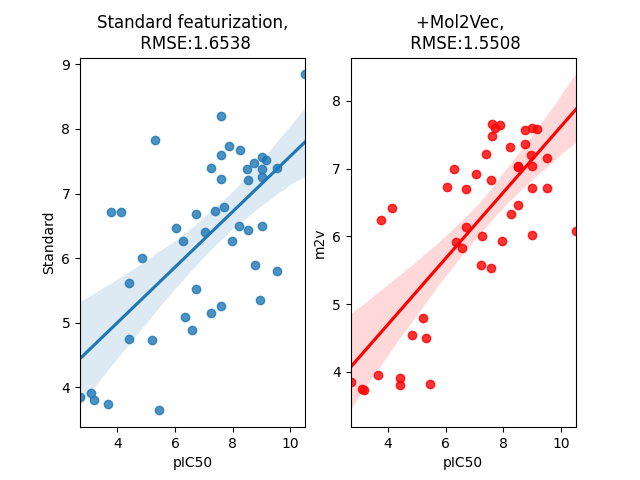

In [118]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

ax1.title.set_text(f'Standard featurization,\n RMSE:{round(rmse,4)}')
sns.regplot(x='pIC50',y='Standard', data= pd_gbt, ax=ax1)

ax2.title.set_text(f'+Mol2Vec, \n RMSE:{round(rmse_m2v,4)}')
sns.regplot(x='pIC50',y='m2v', data= pd_gbt, ax=ax2, color='r')

%matplot plt